# 

In [3]:
import re 
import os
import vrplib
import random
import matplotlib.pyplot as plt

In [3]:
!pip install vrplib

  Using cached vrplib-1.5.1-py3-none-any.whl.metadata (10 kB)
Using cached vrplib-1.5.1-py3-none-any.whl (24 kB)


# load data

In [2]:
def read_all_instances(root_folder, ending='.tsp'):  
    instances = []  

    def extract_k_and_n_numbers(file_name):  
        # Extract 'k' and 'n' numbers from the file name  
        k_match = re.search(r'k(\d+)', file_name)  
        n_match = re.search(r'n(\d+)', file_name)  
        
        # If both match, return both as a tuple (k, n)  
        k = int(k_match.group(1)) if k_match else float('inf')  
        n = int(n_match.group(1)) if n_match else float('inf')  
        return k, n  

    # Sort file names based on (k, n)  
    file_names = sorted(  
        [file_name for file_name in os.listdir(root_folder) if file_name.endswith(ending)],  
        key=extract_k_and_n_numbers  
    )  

    for file_name in file_names:  
        instance = vrplib.read_instance(os.path.join(root_folder, file_name))  
        if instance:  
            instances.append(instance)  
            print(f'Successfully read {file_name}')  
        else:  
            print(f'Failed to read {file_name}')  

    return instances  

In [42]:
#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

Successfully read X-n120-k6.vrp
Successfully read X-n115-k10.vrp
Successfully read X-n139-k10.vrp
Successfully read E-n101-k14.vrp
Successfully read X-n148-k46.vrp


In [43]:
for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print(cvrp_instance['comment'])
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  

    
        #print(f"num_vehicles = {num_vehicles}")  
    #print(f"Vehicle capacity: {vehicle_capacity}")
    #print(f"Demands: {demands}")
    #print(f"Distance matrix: {distance_matrix}")
    #print(f"Node coordinates: {node_coords}")

"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),, Min no of trucks: 6"
"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 10"
"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 10"
(Christophides and Eilon, Min no of trucks: 14, Best value: 1071)
"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 46"


# K-opt 

## 2-Opt

In [4]:
# Function to calculate route distance  计算单条路径(每一辆车)的距离
def calculate_route_distance(route, distance_matrix):
    distance = 0
    if route:
        #route是某一辆车遍历节点的顺序（从0开始）:[37 11 27 22 5 7]
        distance += distance_matrix[0][route[0]]
        for i in range(1, len(route)):
            distance += distance_matrix[route[i-1]][route[i]]
        distance += distance_matrix[route[-1]][0]
    return distance 

# total distances of routes计算总距离
def total_distance(routes, distance_matrix):
    return sum(calculate_route_distance(route, distance_matrix) for route in routes)



def greedy_initial_solution():#生成贪心解
    routes = [[] for _ in range(num_vehicles)]#路径矩阵
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes #先给所有节点都初始化了
    visited[0] = True # starting from the depot

    for vehicle in range(num_vehicles):
        current_node = 0  #所有车辆都遍历到没有满足条件的节点为止
        while True:
            next_node = None
            min_distance = float('inf')
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:#节点i没有访问且现在的负载+节点i需求负载<车辆总负载
                    if distance_matrix[current_node][i] < min_distance:#当前节点到节点i的距离小于最小距离
                        min_distance = distance_matrix[current_node][i]
                        next_node = i
            
            if next_node is None:#没有满足条件的节点了
                break

            routes[vehicle].append(next_node)
            current_load[vehicle] += demands[next_node]
            visited[next_node] = True
            current_node = next_node
    
    return routes

In [5]:
def two_opt_cvrp(route, distance_matrix):
    n = len(route)
    best_route = route[:]
    best_distance = calculate_route_distance(best_route, distance_matrix)
    improvement_found = True


    while improvement_found:
        improvement_found = False

        for i in range(n - 2):
            for j in range(i+2, n):

                current_cost = distance_matrix[best_route[i]][best_route[i+1]] + distance_matrix[best_route[j]][best_route[(j+1) % n]]
                new_cost = distance_matrix[best_route[i]][best_route[j]] + distance_matrix[best_route[i+1]][best_route[(j+1) % n]]

                delta = new_cost - current_cost

                if delta < 0:
                    # it means the improvement found, we will apply 2-opt swap
                    best_route[i+1:j+1] = best_route[i+1:j+1][::-1]
                    best_distance += delta
                    improvement_found = True

    return best_route , best_distance

In [6]:

def optimize_routes_cvrp(routes, distance_matrix):
    optimized_routes = []
    for route in routes:
        optimized_route, _ = two_opt_cvrp(route, distance_matrix)
        optimized_routes.append(optimized_route)
    return optimized_routes

def plot_CVRP_solution(routes, node_coords):

    plt.figure(figsize= (10,8))

    # plot nodes
    for i, (x,y) in enumerate(node_coords):
        plt.scatter(x,y, c = 'blue' if i ==0 else 'red')
        plt.text(x,y, f'{i}', fontsize = 9, ha='right')

    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[0]] + [node_coords[node] for node in route] + [node_coords[0]]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c= colors[vehicle % len(colors)], label=f'Vehicle {vehicle +1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Route Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()


def test_capacity_constraint(routes, demands, vehicle_capacity):
    for vehicle, route in enumerate(routes):
        total_demand = sum(demands[node] for node in route)

        if total_demand > vehicle_capacity:
            print(f'Vechile {vehicle +1} exceeds capacity: {total_demand} > {vehicle_capacity}')
        else:
            print(f'Vehicle {vehicle + 1} is within capacity constraint: {total_demand} <= {vehicle_capacity}')


# Small

Successfully read A-n32-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read A-n48-k7.vrp
Successfully read P-n50-k10.vrp
===================== (Augerat et al, No of trucks: 5, Optimal value: 784) =====================
Number of Nodes: 32
Optimized Routes:  [[30, 26, 14, 29, 22, 18, 7, 1, 12, 16], [24, 27, 20, 5, 25, 10, 8], [6, 3, 2, 23, 28, 4, 11], [13, 21, 31, 19, 17, 9], [15]]
Total Distance:  1168


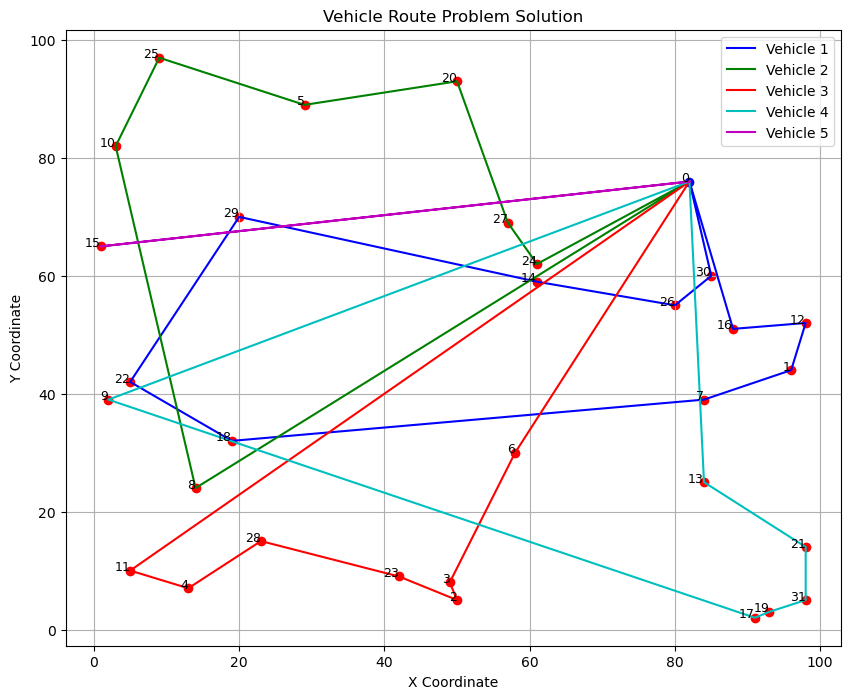

Vehicle 1 is within capacity constraint: 100 <= 100
Vehicle 2 is within capacity constraint: 97 <= 100
Vehicle 3 is within capacity constraint: 95 <= 100
Vehicle 4 is within capacity constraint: 96 <= 100
Vehicle 5 is within capacity constraint: 22 <= 100
===================== (Augerat et al, No of trucks: 5, Optimal value: 669) =====================
Number of Nodes: 37
Optimized Routes:  [[15, 21, 16, 7, 4, 33, 5, 13, 14], [34, 36, 32, 28, 31, 26, 30, 35, 9, 3], [1, 12, 10, 2, 19, 20, 23, 17], [22, 6, 11, 27, 8, 24, 25, 18], [29]]
Total Distance:  892


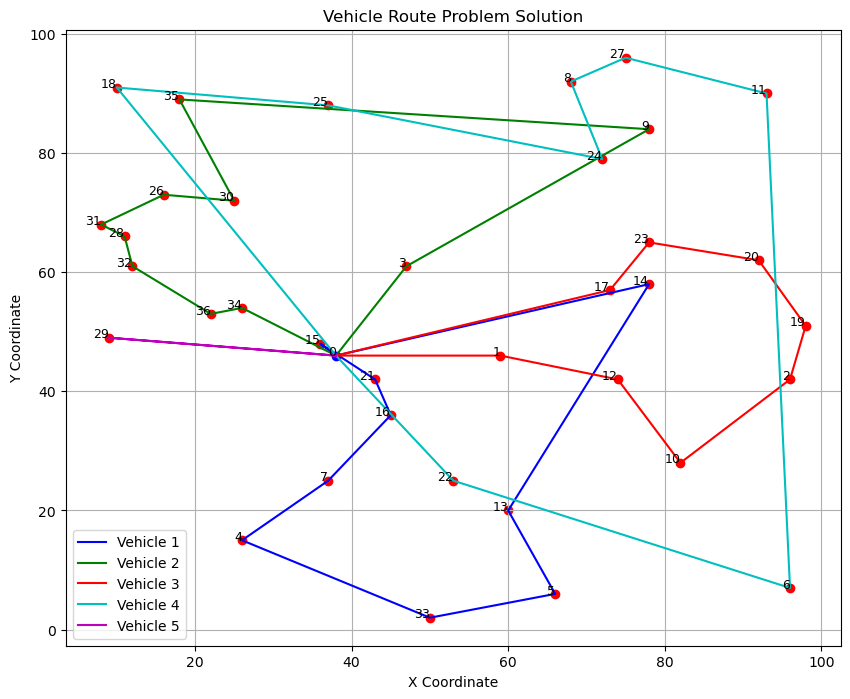

Vehicle 1 is within capacity constraint: 100 <= 100
Vehicle 2 is within capacity constraint: 100 <= 100
Vehicle 3 is within capacity constraint: 99 <= 100
Vehicle 4 is within capacity constraint: 99 <= 100
Vehicle 5 is within capacity constraint: 9 <= 100
===================== (Augerat et al, No of trucks: 7, Optimal value: 1073) =====================
Number of Nodes: 48
Optimized Routes:  [[14, 17, 16, 47, 10, 29, 34, 7], [18, 44, 23, 43, 31, 5, 22, 32, 35], [12, 1, 6, 38, 19, 3, 42], [41, 2, 33, 21, 30, 13, 4, 24], [40, 36, 25, 37, 9, 45], [28, 27, 39, 26, 8, 15], [46, 11, 20]]
Total Distance:  1439


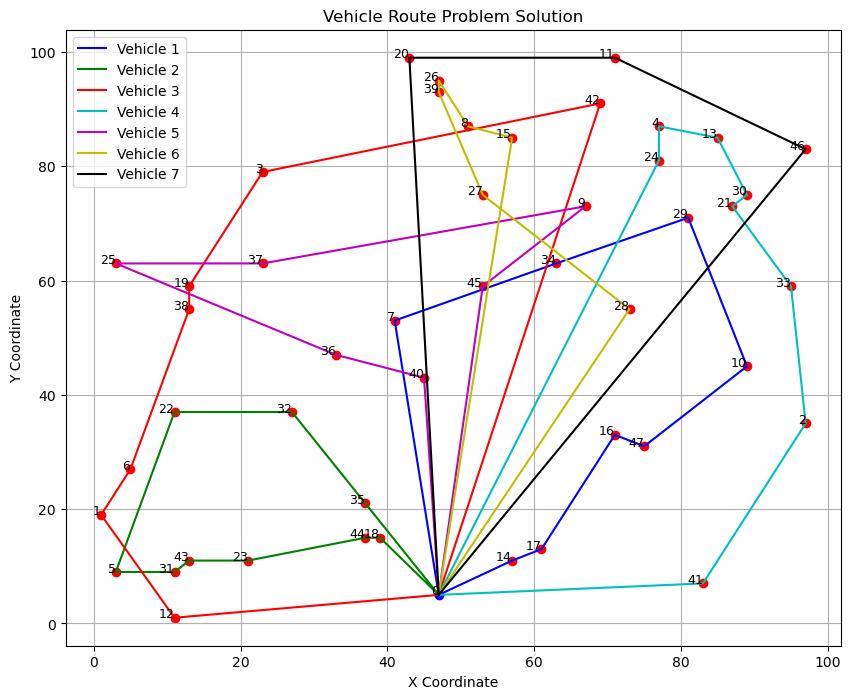

Vehicle 1 is within capacity constraint: 99 <= 100
Vehicle 2 is within capacity constraint: 100 <= 100
Vehicle 3 is within capacity constraint: 100 <= 100
Vehicle 4 is within capacity constraint: 94 <= 100
Vehicle 5 is within capacity constraint: 99 <= 100
Vehicle 6 is within capacity constraint: 88 <= 100
Vehicle 7 is within capacity constraint: 46 <= 100
===================== (Augerat et al, No of trucks: 10, Optimal value: 696) =====================
Number of Nodes: 50
Optimized Routes:  [[26, 12, 40, 3, 17], [4, 34, 46, 8, 15], [6, 2, 30, 48, 29], [7, 35, 19, 14, 38, 49], [45, 27, 13, 5, 37, 36], [33, 1, 43, 42, 41, 23], [16, 44, 32, 9], [39, 10, 31, 25, 18], [28, 21, 47, 20], [11, 24, 22]]
Total Distance:  881


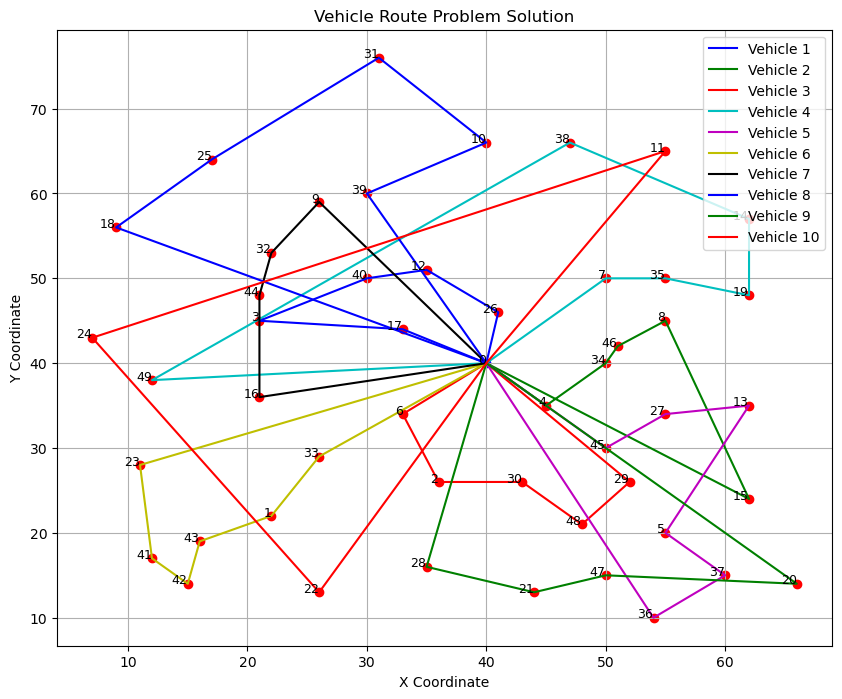

Vehicle 1 is within capacity constraint: 98 <= 100
Vehicle 2 is within capacity constraint: 100 <= 100
Vehicle 3 is within capacity constraint: 100 <= 100
Vehicle 4 is within capacity constraint: 100 <= 100
Vehicle 5 is within capacity constraint: 97 <= 100
Vehicle 6 is within capacity constraint: 95 <= 100
Vehicle 7 is within capacity constraint: 93 <= 100
Vehicle 8 is within capacity constraint: 94 <= 100
Vehicle 9 is within capacity constraint: 98 <= 100
Vehicle 10 is within capacity constraint: 76 <= 100


In [12]:

#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
#root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    initial_routes = greedy_initial_solution()
    optimized_routes = optimize_routes_cvrp(initial_routes, distance_matrix)
    print("Optimized Routes: ", optimized_routes)
    print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
    plot_CVRP_solution(optimized_routes, node_coords)
    # test the capacity constraint
    test_capacity_constraint(optimized_routes, demands, vehicle_capacity)


# Medium

In [48]:
#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
root_folder = './data/cvrp/medium'  
#root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    initial_routes = greedy_initial_solution()
    optimized_routes = optimize_routes_cvrp(initial_routes, distance_matrix)
    print("Optimized Routes: ", optimized_routes)
    print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
    #plot_CVRP_solution(optimized_routes, node_coords)
    # test the capacity constraint
    test_capacity_constraint(optimized_routes, demands, vehicle_capacity)

Successfully read A-n53-k7.vrp
Successfully read A-n63-k10.vrp
Successfully read P-n65-k10.vrp
Successfully read A-n80-k10.vrp
Successfully read E-n76-k14.vrp
===================== (Augerat et al, No of trucks: 7, Optimal value: 1010) =====================
Number of Nodes: 53
Optimized Routes:  [[1, 27, 8, 46, 29, 44, 30, 22, 28, 4, 25], [31, 20, 6, 18, 38, 35, 51, 39], [33, 3, 5, 14, 34, 7], [47, 9, 17, 41, 11, 24, 52], [12, 45, 2, 37, 49, 36, 50, 43, 23, 19, 15], [21, 13, 16, 32, 48, 40], [10, 26, 42]]
Total Distance:  1381
Vehicle 1 is within capacity constraint: 100 <= 100
Vehicle 2 is within capacity constraint: 100 <= 100
Vehicle 3 is within capacity constraint: 99 <= 100
Vehicle 4 is within capacity constraint: 99 <= 100
Vehicle 5 is within capacity constraint: 98 <= 100
Vehicle 6 is within capacity constraint: 100 <= 100
Vehicle 7 is within capacity constraint: 68 <= 100
===================== (Augerat et al, No of trucks: 10, Optimal value: 1314) =====================
Number of

# Large

In [13]:
#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    initial_routes = greedy_initial_solution()
    optimized_routes = optimize_routes_cvrp(initial_routes, distance_matrix)
    print("Optimized Routes: ", optimized_routes)
    print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
    #plot_CVRP_solution(optimized_routes, node_coords)
    # test the capacity constraint
    test_capacity_constraint(optimized_routes, demands, vehicle_capacity)

Successfully read X-n120-k6.vrp
Successfully read X-n115-k10.vrp
Successfully read X-n139-k10.vrp
Successfully read X-n110-k13.vrp
===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),, Min no of trucks: 6" =====================
Number of Nodes: 120
Optimized Routes:  [[20, 116, 107, 61, 119, 10, 94, 84, 55, 70, 93, 16, 80, 29, 25, 73, 31, 38, 52, 88, 50], [96, 71, 49, 2, 43, 76, 64, 113, 9, 99, 13, 98, 82, 109, 42, 39, 78, 3, 45, 112, 54], [32, 91, 67, 30, 118, 79, 33, 23, 14, 58, 83, 15, 44, 18, 26, 5, 41, 103, 17, 12, 21], [87, 72, 102, 111, 34, 27, 11, 56, 1, 24, 37, 59, 22, 4, 95, 60, 100, 77, 57, 40, 62], [8, 114, 90, 6, 92, 35, 53, 81, 69, 68, 85, 89, 51, 63, 104, 105, 101, 47, 66, 108, 117], [36, 115, 48, 86, 65, 74, 110, 106, 7, 97, 46, 75, 19, 28]]
Total Distance:  15188
Vehicle 1 is within capacity constraint: 21 <= 21
Vehicle 2 is within capacity constraint: 21 <= 21
Vehicle 3 is within capacity constraint: 21 <= 21
Vehicle 4 is wit

# Solved

Successfully read A-n45-k6.vrp
Successfully read P-n60-k10.vrp
Successfully read E-n101-k14.vrp
===================== (Augerat et al, No of trucks: 6, Optimal value: 944) =====================
Number of Nodes: 45
Optimized Routes:  [[23, 9, 10, 20, 13, 32, 7, 28], [14, 35, 1, 44, 6, 19, 11, 26, 2], [38, 25, 12, 42, 4, 41, 22, 15], [29, 27, 43, 18, 17, 5], [31, 24, 37, 34, 40], [3, 21, 33, 8, 16, 36, 39]]
Total Distance:  1265


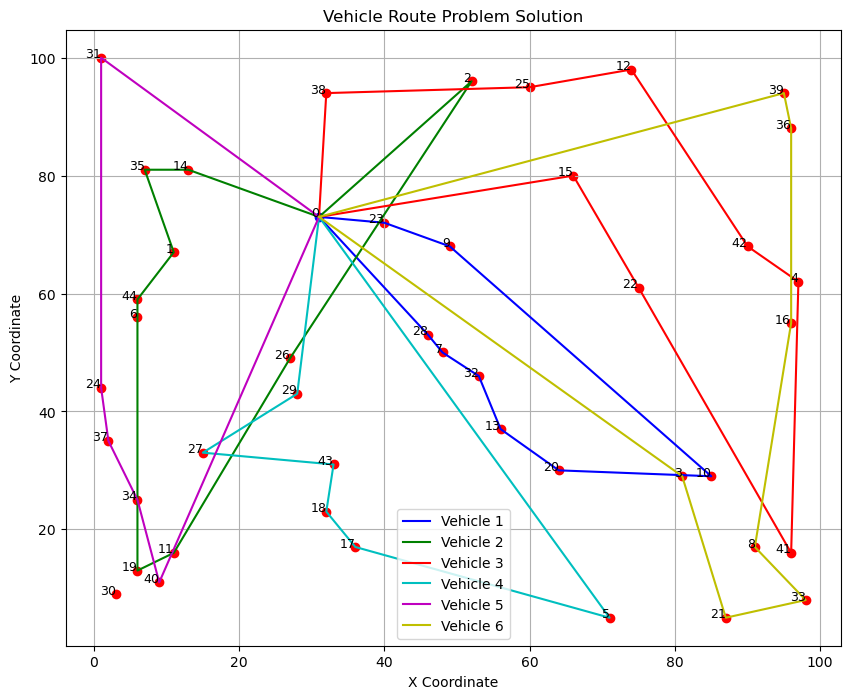

Vehicle 1 is within capacity constraint: 99 <= 100
Vehicle 2 is within capacity constraint: 99 <= 100
Vehicle 3 is within capacity constraint: 99 <= 100
Vehicle 4 is within capacity constraint: 97 <= 100
Vehicle 5 is within capacity constraint: 93 <= 100
Vehicle 6 is within capacity constraint: 95 <= 100
===================== (Augerat et al, No of trucks: 10, Optimal value: 744) =====================
Number of Nodes: 60
Optimized Routes:  [[26, 12, 40, 17, 51, 6], [4, 34, 46, 8, 35, 7], [2, 30, 48, 29, 27, 45], [52, 13, 54, 19, 14, 53, 49], [33, 22, 42, 41, 43, 1, 23, 3], [16, 44, 32, 9, 39, 55], [58, 10, 38, 11, 15], [28, 21, 47, 36, 37, 57], [5, 20, 59, 56, 24], [50, 18, 25, 31]]
Total Distance:  956


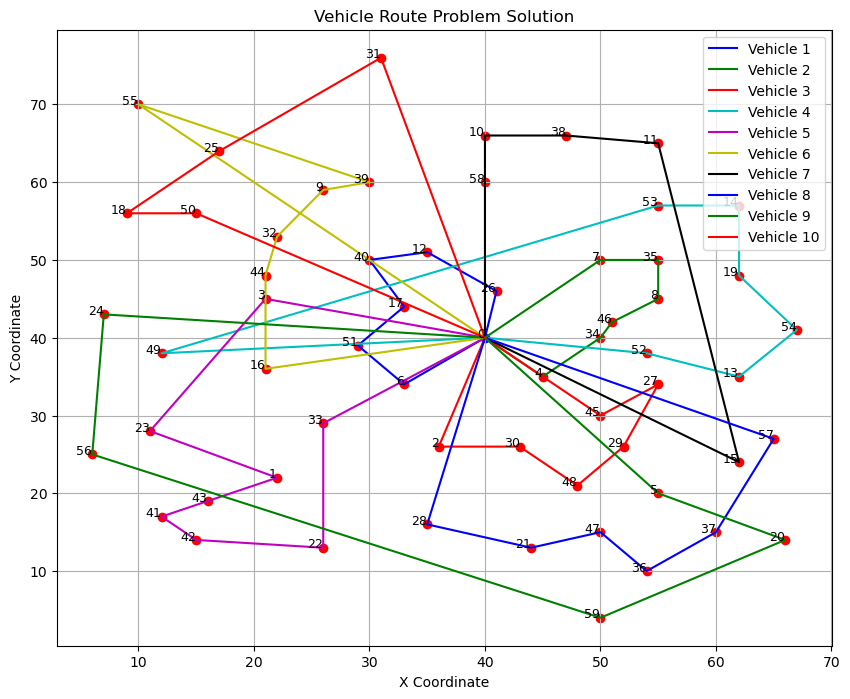

Vehicle 1 is within capacity constraint: 118 <= 120
Vehicle 2 is within capacity constraint: 117 <= 120
Vehicle 3 is within capacity constraint: 119 <= 120
Vehicle 4 is within capacity constraint: 120 <= 120
Vehicle 5 is within capacity constraint: 118 <= 120
Vehicle 6 is within capacity constraint: 116 <= 120
Vehicle 7 is within capacity constraint: 116 <= 120
Vehicle 8 is within capacity constraint: 116 <= 120
Vehicle 9 is within capacity constraint: 120 <= 120
Vehicle 10 is within capacity constraint: 74 <= 120
===================== (Christophides and Eilon, Min no of trucks: 14, Best value: 1071) =====================
Number of Nodes: 101
Optimized Routes:  [[53, 58, 22, 74, 72, 73, 21, 40], [27, 28, 26, 55, 80, 68, 12], [89, 6, 94, 95, 92, 37, 98, 93, 91, 17, 46], [13, 97, 100, 42, 43, 15, 57, 2, 87], [52, 18, 60, 5, 84, 83, 45, 8, 82, 90], [69, 1, 50, 33, 79, 78, 24, 3, 77, 76], [96, 99, 59, 85, 61, 7, 70], [31, 88, 62, 19, 11, 63, 10], [54, 4, 75, 41, 23, 56, 25, 29], [30, 51, 8

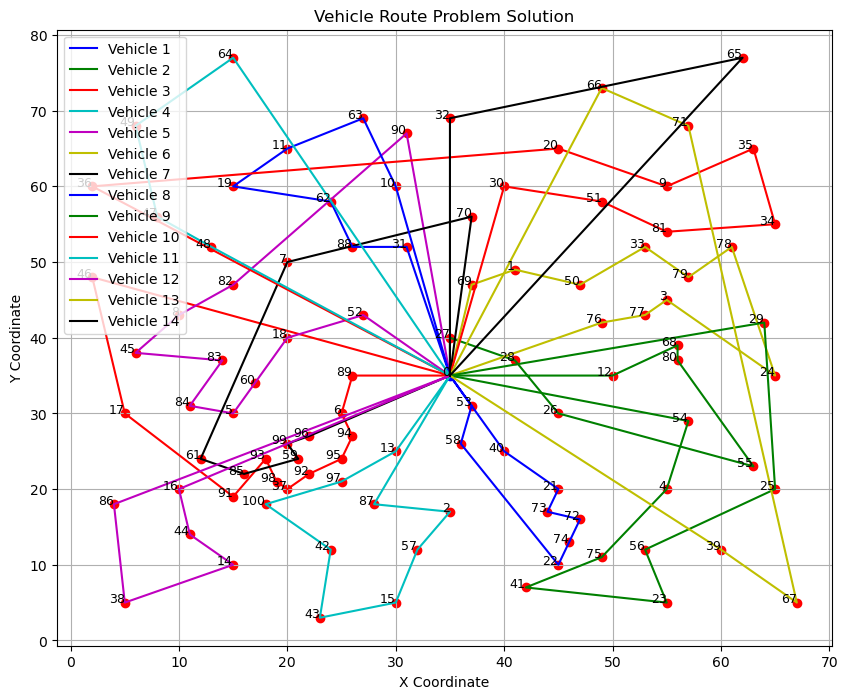

Vehicle 1 is within capacity constraint: 112 <= 112
Vehicle 2 is within capacity constraint: 112 <= 112
Vehicle 3 is within capacity constraint: 111 <= 112
Vehicle 4 is within capacity constraint: 112 <= 112
Vehicle 5 is within capacity constraint: 112 <= 112
Vehicle 6 is within capacity constraint: 109 <= 112
Vehicle 7 is within capacity constraint: 112 <= 112
Vehicle 8 is within capacity constraint: 110 <= 112
Vehicle 9 is within capacity constraint: 110 <= 112
Vehicle 10 is within capacity constraint: 109 <= 112
Vehicle 11 is within capacity constraint: 102 <= 112
Vehicle 12 is within capacity constraint: 108 <= 112
Vehicle 13 is within capacity constraint: 96 <= 112
Vehicle 14 is within capacity constraint: 43 <= 112


In [53]:
#root_folder = './data/cvrp/new_data/'  
root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
#root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    initial_routes = greedy_initial_solution()
    optimized_routes = optimize_routes_cvrp(initial_routes, distance_matrix)
    print("Optimized Routes: ", optimized_routes)
    print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
    plot_CVRP_solution(optimized_routes, node_coords)
    # test the capacity constraint
    test_capacity_constraint(optimized_routes, demands, vehicle_capacity)